## Classic semantic segmentation network.

In [ ]:
SAVE_ON_DRIVE = True
TYPE = 'Test'

## Dataset initialization


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/LoveDA/Train'
if (os.path.exists("./Train") == False):
    if (os.path.exists("/content/drive/MyDrive/LoveDA/Train.zip")):
        print("Dataset available on own drive, unzipping...")
        !unzip -q /content/drive/MyDrive/LoveDA/Train.zip -d ./
    else:
        print("Downloading dataset...")
        !wget -O Train.zip "https://zenodo.org/records/5706578/files/Train.zip?download=1"
        if(SAVE_ON_DRIVE):
            print("Saving dataset on drive...")
            !cp Train.zip /content/drive/MyDrive/LoveDA/
        !unzip -q Train.zip -d ./

else:
    print("Dataset already in local")

Mounted at /content/drive
--2024-12-29 21:14:48--  https://zenodo.org/records/5706578/files/Train.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4021669263 (3.7G) [application/octet-stream]
Saving to: ‘Train.zip’

Train.zip           100%[===================>]   3.75G  12.4MB/s    in 5m 15s  

2024-12-29 21:20:04 (12.2 MB/s) - ‘Train.zip’ saved [4021669263/4021669263]

Saving dataset on drive...
cp: failed to access '/content/drive/MyDrive/LoveDA/': Not a directory


## DataSet initialization

In [ ]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T
import random

RESIZE = 256

def pil_loader(path, color_type):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert(color_type)

class LoveDADataset(Dataset):
    def __init__(self, split = 'Urban', type = 'Train', validation_ratio=0.2, seed=265637):
        # Validate type input
        if type not in ['Train', 'Validation']:
            raise ValueError("Invalid type. Expected 'Train' or 'Validation'.")

        self.directory = []
        directory_path = os.path.join('./Train', split, 'images_png')

        # Check if the directory exists
        if not os.path.exists(directory_path):
            raise FileNotFoundError(f"Directory not found: {directory_path}")

        # Get all image paths
        all_images = [os.path.join(directory_path, entry) for entry in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, entry))]

        # Shuffle images for random splitting
        random.seed(seed)
        random.shuffle(all_images)

        # Split into training and validation sets
        split_idx = int(len(all_images) * (1 - validation_ratio))
        if type == 'Train':
            self.directory = all_images[:split_idx]
        elif type == 'Validation':
            self.directory = all_images[split_idx:]
        else:
            raise ValueError("Invalid type. Expected 'Train' or 'Validation'.")


      # Define albumentations transforms
        """
        # WITH AUGMENTATIONS
          self.transform = A.Compose([
            A.RandomCrop(256, 256),
            A.OneOf([
                A.HorizontalFlip(p=1),
                A.VerticalFlip(p=1),
                A.RandomRotate90(p=1)
            ], p=0.75),
            A.Normalize(mean=(123.675, 116.28, 103.53),
                        std=(58.395, 57.12, 57.375),
                        max_pixel_value=1.0, always_apply=True),
            ToTensorV2()
        ])
      """

    def __len__(self):
        return len(self.directory)

    def __getitem__(self, idx):
        image_path = self.directory[idx]
        image = pil_loader(image_path, 'RGB')
        mask_path = image_path.replace('images_png', 'masks_png')

        mask = pil_loader(mask_path, 'L')

        img_transform = T.Compose([
              T.Resize((RESIZE, RESIZE)),
              T.ToTensor(),
          ])
        mask_transform = T.Compose([
              T.Resize((RESIZE, RESIZE)),
          ])

        # Apply transformations
        image = img_transform(image)
        mask = mask_transform(mask)
        mask = np.array(mask)
        mask = torch.from_numpy(mask).long()
        mask = mask-1

        return image, mask, image_path

## Useful functions

In [ ]:
from collections import OrderedDict
COLOR_MAP = OrderedDict(
    Background=(255, 255, 255),
    Building=(255, 0, 0),
    Road=(255, 255, 0),
    Water=(0, 0, 255),
    Barren=(159, 129, 183),
    Forest=(34, 139, 34),
    Agricultural=(255, 195, 128),
)

LABEL_MAP = OrderedDict(
    Background=0,
    Building=1,
    Road=2,
    Water=3,
    Barren=4,
    Forest=5,
    Agricultural=6,
)
inverted_label_map = OrderedDict((v, k) for k, v in LABEL_MAP.items())


def getLabelColor(label):
    # Default color for unclassified labels
    default_color = np.array([128, 128, 128])  # Gray

    # Check if label exists in inverted_label_map
    label_name = inverted_label_map.get(label, None)
    if label_name is None or label_name not in COLOR_MAP:
        return default_color  # Return default color for unclassified

    # Return the mapped color
    label_color = np.array(COLOR_MAP[label_name])
    return label_color


def getLegendHandles():
  handles = [mpatches.Patch(color=getLabelColor(i)/255, label=inverted_label_map[i]) for i in range(0, len(LABEL_MAP))]
  handles.append(mpatches.Patch(color=getLabelColor(-1)/255, label='Unclassified'))
  return handles

def new_colors_mask(mask):
  new_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
  for i, row in enumerate(mask):
    for j, cell in enumerate(row):
      new_image[i][j] = getLabelColor(cell.item())
  return new_image



## Try dataset

232


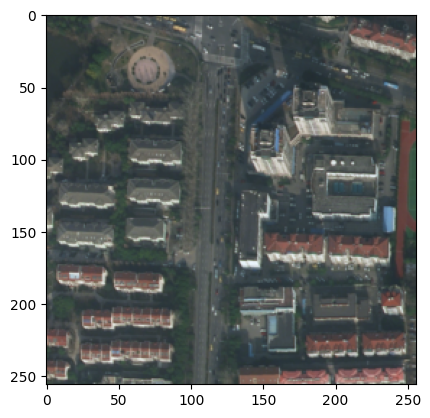

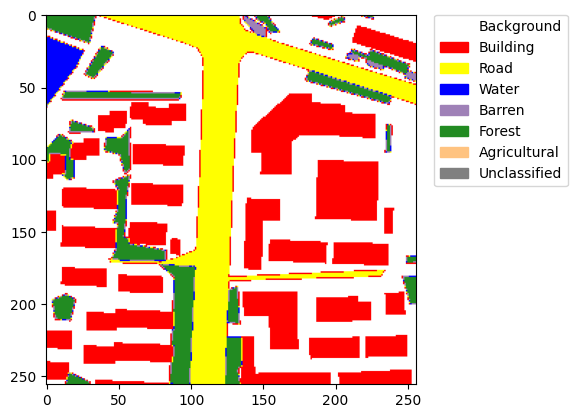

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import matplotlib.patches as mpatches

train_dataset = LoveDADataset(type='Validation', seed=222)
print(train_dataset.__len__())

image, mask, _ = train_dataset.__getitem__(88)
image = image.permute(1, 2, 0)
image = image.numpy()
plt.imshow(image)

new_image = new_colors_mask(mask)
plt.imshow(image)
plt.show()
plt.legend(handles=getLegendHandles(), loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.imshow(new_image)
plt.show()




## Initialize model

In [ ]:
import torch
import torch.nn as nn

affine_par = True

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, affine=affine_par)
        for i in self.bn1.parameters():
            i.requires_grad = False
        padding = dilation
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=padding, bias=False, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(planes, affine=affine_par)
        for i in self.bn2.parameters():
            i.requires_grad = False
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4, affine=affine_par)
        for i in self.bn3.parameters():
            i.requires_grad = False
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out


class ClassifierModule(nn.Module):
    def __init__(self, inplanes, dilation_series, padding_series, num_classes):
        super(ClassifierModule, self).__init__()
        self.conv2d_list = nn.ModuleList()
        for dilation, padding in zip(dilation_series, padding_series):
            self.conv2d_list.append(
                nn.Conv2d(inplanes, num_classes, kernel_size=3, stride=1, padding=padding,
                          dilation=dilation, bias=True))

        for m in self.conv2d_list:
            m.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.conv2d_list[0](x)
        for i in range(len(self.conv2d_list) - 1):
            out += self.conv2d_list[i + 1](x)
        return out


class ResNetMulti(nn.Module):
    def __init__(self, block, layers, num_classes):
        self.inplanes = 64
        super(ResNetMulti, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, affine=affine_par)
        for i in self.bn1.parameters():
            i.requires_grad = False
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)  # change
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1, dilation=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, dilation=4)
        self.layer6 = ClassifierModule(2048, [6, 12, 18, 24], [6, 12, 18, 24], num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.01)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1):
        downsample = None
        if (stride != 1
                or self.inplanes != planes * block.expansion
                or dilation == 2
                or dilation == 4):
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, affine=affine_par))
        for i in downsample._modules['1'].parameters():
            i.requires_grad = False
        layers = []
        layers.append(
            block(self.inplanes, planes, stride, dilation=dilation, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        _, _, H, W = x.size()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer6(x)

        x = torch.nn.functional.interpolate(x, size=(H, W), mode='bilinear')

        if self.training == True:
            return x, None, None

        return x

    def get_1x_lr_params_no_scale(self):
        """
        This generator returns all the parameters of the net except for
        the last classification layer. Note that for each batchnorm layer,
        requires_grad is set to False in deeplab_resnet.py, therefore this function does not return
        any batchnorm parameter
        """
        b = []

        b.append(self.conv1)
        b.append(self.bn1)
        b.append(self.layer1)
        b.append(self.layer2)
        b.append(self.layer3)
        b.append(self.layer4)

        for i in range(len(b)):
            for j in b[i].modules():
                jj = 0
                for k in j.parameters():
                    jj += 1
                    if k.requires_grad:
                        yield k

    def get_10x_lr_params(self):
        """
        This generator returns all the parameters for the last layer of the net,
        which does the classification of pixel into classes
        """
        b = []
        if self.multi_level:
            b.append(self.layer5.parameters())
        b.append(self.layer6.parameters())

        for j in range(len(b)):
            for i in b[j]:
                yield i

    def optim_parameters(self, lr):
        return [{'params': self.get_1x_lr_params_no_scale(), 'lr': lr},
                {'params': self.get_10x_lr_params(), 'lr': 10 * lr}]


def get_deeplab_v2(num_classes=19, pretrain=True, pretrain_model_path='DeepLab_resnet_pretrained_imagenet.pth'):
    model = ResNetMulti(Bottleneck, [3, 4, 23, 3], num_classes)

    # Pretraining loading
    if pretrain:
        print('Deeplab pretraining loading...')
        saved_state_dict = torch.load(pretrain_model_path)

        new_params = model.state_dict().copy()
        for i in saved_state_dict:
            i_parts = i.split('.')
            new_params['.'.join(i_parts[1:])] = saved_state_dict[i]
        model.load_state_dict(new_params, strict=False)

    return model

## Get Pre Trained weights

In [ ]:
#!pip install gdown

In [ ]:
import gdown

# File ID and destination path
file_id = "1ZX0UCXvJwqd2uBGCX7LI2n-DfMg3t74v"
url = f"https://drive.google.com/uc?id={file_id}"
output = "deeplab_resnet_pretrained_imagenet.pth"


if (os.path.exists("/content/drive/MyDrive/LoveDA/" + output)):
    print("Pre Trained model available on Drive")
    if (os.path.exists("./deeplab_resnet_pretrained_imagenet.pth") == False):
      !cp /content/drive/MyDrive/LoveDA/deeplab_resnet_pretrained_imagenet.pth ./deeplab_resnet_pretrained_imagenet.pth
    else:
      print("Pre Trained model already in local")
else:
    print("Downloading deeplab_resnet_pretrained_imagenet.pth...")
    gdown.download(url, output, quiet=False)
    if SAVE_ON_DRIVE:
      print("Saving pre-trained model on drive")
      !cp /content/deeplab_resnet_pretrained_imagenet.pth /content/drive/MyDrive/LoveDA/deeplab_resnet_pretrained_imagenet.pth

Downloading...
From (original): https://drive.google.com/uc?id=1ZX0UCXvJwqd2uBGCX7LI2n-DfMg3t74v
From (redirected): https://drive.google.com/uc?id=1ZX0UCXvJwqd2uBGCX7LI2n-DfMg3t74v&confirm=t&uuid=b8abaac0-4aad-4c40-9632-4d6102784995
To: /content/deeplab_resnet_pretrained_imagenet.pth
100%|██████████| 177M/177M [00:01<00:00, 103MB/s]


Saving pre-trained model on drive
cp: failed to access '/content/drive/MyDrive/LoveDA/deeplab_resnet_pretrained_imagenet.pth': Not a directory


## Training & Dataset creation

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 20      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10
NUM_CLASSES = len(LABEL_MAP)
BATCH_SIZE = 24

In [ ]:
if SAVE_ON_DRIVE:
  if TYPE != 'Train':
    !cp /content/drive/MyDrive/LoveDA/best_model.pth ./best_model.pth

cp: cannot stat '/content/drive/MyDrive/LoveDA/best_model.pth': Not a directory


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

pretrain_model_path = 'deeplab_resnet_pretrained_imagenet.pth'
path = './best_model.pth'
if TYPE == 'Train':
  path = pretrain_model_path
else:
  path = path
num_classes = len(LABEL_MAP)
model = get_deeplab_v2(num_classes=num_classes, pretrain=True, pretrain_model_path=path)

#loss = SegmentationLoss(loss_config={'ce': True})

# Example optimizer
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

train_dataset = LoveDADataset(split='Urban', type='Train', validation_ratio=0.2)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)

validation_dataset = LoveDADataset(split='Urban', type='Validation', validation_ratio=0.2)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)


Deeplab pretraining loading...


<ipython-input-6-bae244a7c21c>:179: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state_dict = torch.load(pretrain_model_path)


FileNotFoundError: [Errno 2] No such file or directory: './best_model.pth'

In [ ]:

# Enable CUDA launch blocking for better debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Enable CUDA device-side assertions
os.environ['TORCH_USE_CUDA_DSA'] = '1'

# cudnn.benchmark # Calling this optimizes runtime
model = model.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

current_step = 0
# Start iterating over the epochs

best_loss = float('inf')
best_model = model.state_dict()

print(f"DEVICE is {DEVICE}")
if TYPE == 'Train':
  for epoch in range(NUM_EPOCHS):
      model.train()
      print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
      epoch_loss = [0.0, 0]
      for (i, batch) in enumerate(train_loader):
          optimizer.zero_grad()

          # Extract input
          images, masks, image_path = batch
          images = images.float().to(DEVICE)
          masks = masks.to(DEVICE)

          # Forward to get output and loss
          outputs, _, _ = model(images)
          outputs = outputs.to(DEVICE)

          loss = F.cross_entropy(outputs, masks, ignore_index=-1)
          print(f'Loss at batch {i}: {loss.item()}')
          loss.backward()
          optimizer.step()
          epoch_loss[0] += loss.item()
          epoch_loss[1] += images.size(0)


      # Evaluate model on the evaluation set and save the parameters if is better than best model
      model.eval()
      total_loss = 0.0
      outputs = []
      with torch.no_grad():
        for batch in validation_loader:
          images, masks, _ = batch
          images = images.float().to(DEVICE)
          masks = masks.to(DEVICE)
          # Forward Pass
          outputs = model(images)
          outputs = outputs.to(DEVICE)
          loss = F.cross_entropy(outputs, masks, ignore_index=-1)
          total_loss += loss.item()

      print('Epoch {}, Loss {}'.format(epoch+1, total_loss))
      if total_loss < best_loss:
        best_loss = total_loss
        best_model = model.state_dict()
        #Save in Drive and local
        torch.save(best_model, 'best_model.pth')
        if SAVE_ON_DRIVE:
          !cp best_model.pth /content/drive/MyDrive/LoveDA/best_model.pth


      current_step += 1
      scheduler.step()
      print(f'[EPOCH {epoch+1}] Avg. Loss: {epoch_loss[0] / epoch_loss[1]}')



## Debugging fossils

In [ ]:
# # # Good paths
# # './Train/Urban/images_png/1458.png'
# # './Train/Urban/images_png/1549.png'

# # # Bad paths
# # './Train/Urban/images_png/1788.png'
# # './Train/Urban/images_png/2300.png'

# # ============ Load =============
# image_path = './Train/Urban/images_png/2300.png'
# image = pil_loader(image_path, 'RGB')
# mask_path = image_path.replace('images_png', 'masks_png')
# mask = pil_loader(mask_path, 'L')

# img_transform = T.Compose([
#       T.Resize((256, 256)),
#       T.ToTensor(),
#   ])
# mask_transform = T.Compose([
#       T.Resize((256, 256)),
#   ])


# image = img_transform(image)
# mask = mask_transform(mask)
# mask = np.array(mask)
# mask = mask-1
# mask = torch.from_numpy(mask).long()

# # ========== show ===============
# img_to_show = image.permute(1, 2, 0)
# img_to_show = img_to_show.numpy()
# print(f"image shape is {img_to_show.shape}")
# plt.imshow(img_to_show)
# plt.show()

# mask_to_show = np.array(mask)
# toShow = new_colors_mask(mask)
# plt.legend(handles=getLegendHandles(), loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.5)
# plt.imshow(toShow)
# plt.show()
# print(f"mask shape is {mask_to_show.shape}")


# =============== loss ==============
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['TORCH_USE_CUDA_DSA'] = '1'

# image = image.to('cuda')
# mask = mask.to('cuda')
# model = model.to('cuda')

# image = image.reshape([1, 3, 256, 256])
# mask = mask.reshape([1, 256, 256])

# output, _, _ = model(image)
# output = output.to('cuda')

# print(f"output shape is {output.shape}")
# print(f"mask shape is {mask.shape}")
# # for batch in mask:
# #   for row in batch:
# #     for cell in row:
# #       if cell.cpu().numpy() > 6 :
# #         print(cell.cpu().numpy())
# #         break
# ce_loss = F.cross_entropy(output, mask, ignore_index=7)
# print(f'Cross Entropy Loss: {ce_loss.item()}')



## TEST

In [ ]:
!pip install torchmetrics ptflops

In [ ]:
from torchmetrics import Accuracy
from tqdm import tqdm
import time
import ptflops

#Load best_model
best_model = torch.load('/content/best_model.pth', weights_only=True)
model.load_state_dict(best_model)
model = model.to(DEVICE)

accuracy, mIoU = True, True

#### TEST LOOP
model.eval()

# Latency
with torch.no_grad():
    start_time = time.time()
    for _ in range(100):
        _ = model(torch.randn(1, 3, RESIZE, RESIZE).to(DEVICE))
    end_time = time.time()
latency = (end_time - start_time) / 100
print(f"Latency: {latency:.4f} seconds")

# FLOPs
macs, _ = ptflops.get_model_complexity_info(model,
  (3, RESIZE, RESIZE), as_strings=False,
  print_per_layer_stat=False, verbose=False)
flops = macs * 2  # MACs perform two FLOPs
print("FLOPs:", flops)

# Number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

if TYPE == 'Test':
  with torch.no_grad():
      total_union = torch.zeros(NUM_CLASSES).to(DEVICE)
      total_intersection = torch.zeros(NUM_CLASSES).to(DEVICE)
      meter = Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(DEVICE)
      for batch_img, batch_mask, _ in tqdm(validation_loader):
          batch_img, batch_mask = batch_img.to(DEVICE), batch_mask.to(DEVICE)

          # Forward pass
          cls_o = model(batch_img)
          cls_o = cls_o.to(DEVICE)
          # Shape: NBATCHES x classes x h x w
          class_indices = torch.argmax(cls_o, dim=1)  # Shape: NBATCHES x h x w

          if accuracy:
          # Create a mask for valid targets (where target is not -1)
            valid_mask = (batch_mask != -1)  # Mask of shape: NBATCHES x h x w
            # Apply the mask to ignore -1 targets when updating the accuracy metric
            meter.update(class_indices[valid_mask], batch_mask[valid_mask])

          if mIoU:
            for predicted, target in zip(class_indices, batch_mask):
              for i in range(NUM_CLASSES):
                total_intersection[i] += torch.sum(torch.logical_and(predicted == i, target == i))
                total_union[i] += torch.sum(torch.logical_or(predicted == i, target == i))

  if accuracy:
    accuracy = meter.compute()
    print(f'\nAccuracy on the target domain: {100 * accuracy:.2f}%')

  if mIoU:
    intersection_over_union = total_intersection / total_union
    mIoU = torch.mean(intersection_over_union)
    print(f'\nmIoU on the target domain: {mIoU}')
